In [1]:
from IPython.display import display, HTML, Markdown
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import random
import numpy.random as rd
import matplotlib.pyplot as plt

import import_ipynb
import sys
#import boris_stepper
from Functions import push_particles

import pandas as pd
from pandas import Series, DataFrame
from scipy.optimize import curve_fit 

%matplotlib inline
%matplotlib notebook

importing Jupyter notebook from Functions.ipynb


In [3]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'

In [4]:
path_in = 'C:\\Users\\mathe\\OneDrive\\Área de Trabalho\\Monte Carlo\\23102023\\Evento07102015\\'

* ### Constantes

In [5]:
c      = 299792458  # velocidade da luz em m/s
dt     = 1e-2       # passo temporal em segundos.
Nsteps = 4000       # número de passos temporais. 2000
skip   = 1          # Taxa de pulos no dados salvos.

t=np.zeros(int(Nsteps/skip)+1)
t[0] = 0.0  

In [6]:
# Definição dos parâmetros relevantes para o inicio da simulação.

# Carga da partícula. +1 para próton, e -1 para elétron
q =  1.0
qe = 1.60217662e-19 # carga elementar.

# Massa da partícula em função da massa do elétron
m = 1.836e3
me= 9.10938356e-31 # massa do elétron em kg.

# rest mass energy in eV
# magnetic permeability of vacuum.
muo=4*np.pi*1e-7

# Razão dos calores específicos ratio of specific heats
gamma   = 2
gamma_3 = 5/3

##  Parâmetros físicos pré-choques obtidos no evento do dia 07/10/2015

In [7]:
v1 = [-421.458008, -27.801001, 20.910]          # km/s
B1 = [-8.032000, 12.403000, 6.124]              # nT
n1 = 21.268999                                  # cm^-3
T1 = 39.785000                                  # eV
# vetor normal ao plano de choque
n = [0.8921752 ,  0.43381014, -0.12582624]

## Transformações referentes aos valores normais e tangenciais 

### Módulo da velocidade na região pré-choque

In [8]:
round(np.linalg.norm(v1),3)          # km/s

422.891

In [9]:
v1n = np.abs(np.dot(v1,n)*1e3)                         # Velocidade pré-choque normal ao plano de choque        [m/s]
B1n = np.dot(B1,n)                                     # Campo magnético pré-choque normal ao plano de choque   

B1t = np.sqrt(np.linalg.norm(B1)**2 - B1n**2)*1e-9     # Campo magnético pré-choque tangente ao plano de choque [T]

B1u = np.array([0,0,B1t])                              # vetor B1t na direção z

### Velocidade pré-choque na direção do vetor normal n

In [10]:
round(v1n,3)     # m/s 

390705.765

### Campo magnético na direção perpendicular ao vetor normal n

In [11]:
round(B1t/1e-9, 3)   #nT

15.79

In [12]:
B1u           # vetor

array([0.00000000e+00, 0.00000000e+00, 1.57898023e-08])

### Parâmetros derivados

In [13]:
# derived parameters

Eu = -np.cross(np.array([0,v1n,0]),np.array([0,0,B1t]))    # electric field. The same on both sides.
p1 = 2*n1*1e6*1.3806e-23*(T1*1.1604e4)                     # thermal pressure in Pa 
                                                        # (the "2" comes from p = pi + pe = n1*k_B*(Ti+Te)=2*n1*k_B*T1).
rho1 = n1*(m*me)*1e6                                       # particle mass density in kg/m^3.
R1 = np.sqrt(p1/rho1)*(m*me)/((np.abs(q)*1.602e-19)*B1t)   # thermal gyroradius in m.

In [14]:
print('{:.3e}'.format(m*me))   # Massa em kg

1.672e-27


In [15]:
print('{:.3e}'.format(np.abs(q)*1.602e-19))  # Carga em C

1.602e-19


In [16]:
round(R1,3)

57723.692

In [17]:
em = 0.5*(rho1*(v1n**2)+B1t**2/(muo))+p1
    
zeta = ( (2*gamma*em-rho1*(v1n**2))
+ np.sqrt((2*gamma*em-rho1*(v1n**2))**2 - 4*rho1*(gamma+1)*(gamma-2)*(v1n*B1t)**2/muo ) )/(2*rho1*(gamma+1)*v1n**2)

zeta_3 = ( (2*gamma_3*em-rho1*(v1n**2))
+ np.sqrt((2*gamma_3*em-rho1*(v1n**2))**2 - 4*rho1*(gamma_3+1)*(gamma_3-2)*(v1n*B1t)**2/muo ) )/(2*rho1*(gamma_3+1)*v1n**2)

round(zeta,3), round(zeta_3,3)

(0.424, 0.348)

In [18]:
round(1/zeta,3), round(1/zeta_3,3)

(2.357, 2.871)

In [19]:
gamma, gamma_3

(2, 1.6666666666666667)

## Tabela com os parâmetros de entrada

In [20]:
zz_1 = round(1/zeta,3)
Tb_1 = [[dt,round(v1n/1e3,3),round(B1t/1e-9, 3),round(Eu[0]*1e3,3), gamma, round(zeta,3), zz_1 ],
        [dt,round(v1n/1e3,3),round(B1t/1e-9, 3),round(Eu[0]*1e3,3), gamma_3, round(zeta_3,3),round(1/zeta_3,3) ]
       ]

Tb_1

[[0.01, 390.706, 15.79, -6.169, 2, 0.424, 2.357],
 [0.01, 390.706, 15.79, -6.169, 1.6666666666666667, 0.348, 2.871]]

In [21]:
df1 = pd.DataFrame(Tb_1, columns = ['$\Delta t$','$V_{1,n}$','$B_{1,t}$','$E_1$','$\gamma$', '$r$', '$\zeta $'], index=['2D', '3D'])
df1

,$\Delta t$,"$V_{1,n}$","$B_{1,t}$",$E_1$,$\gamma$,$r$,$\zeta $
2D,0.01,390.706,15.79,-6.169,2.000000,0.424,2.357
3D,0.01,390.706,15.79,-6.169,1.666667,0.348,2.871


In [22]:
df1[['$\Delta t$','$V_{1,n}$','$B_{1,t}$','$E_1$','$\gamma$', '$r$', '$\zeta $']].rename(
    columns = {'$\Delta t$':'$\Delta t \ [s]$',
               '$V_{1,n}$':'$\mathbf{V} \left[ \dfrac{km}{s} \right]$',
               '$B_{1,t}$':'$\mathbf{B} \ [nT]$',
               '$E_1$':'$\mathbf{E}_1 = \mathbf{E}_2 \ [mV]$',
               '$\gamma$':'$\gamma \left [\dfrac{C_P}{C_V} \right]$'  ,
               '$r$':'$r$', 
               '$\zeta $':r"$\zeta = 1/r$"}).to_latex('Parametros_de_entrada_07102015.tex', 
                                                                          caption = 'Parâmetros de entrada da simulação para o evento do dia 07/10/2015',
                                                                          column_format ='c|ccccccc',
                                                                          escape = False)

## Carregamento dos dados 

In [22]:
vxi = np.loadtxt(path_in+'Vx_MB.txt'); v_d = np.loadtxt(path_in+'Vy_MB.txt'); vzi = np.loadtxt(path_in+'Vz_MB.txt'); n = np.loadtxt(path_in+'n.txt')

# Simulação boris 2 D

In [23]:
# ------------------------------------------------------
# Loop over the "npart" particles.
# ------------------------------------------------------
# Boundaries of the simulation box in the X-direction. 

x0lower = -5.0
x0upper = 5.0 

# Geração das posições em x
x = x0lower+rd.random(len(v_d))*(x0upper-x0lower)

rx = np.zeros([int(Nsteps/skip)+1,len(v_d)]); ry = np.zeros([int(Nsteps/skip)+1,len(v_d)]); rz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
vx = np.zeros([int(Nsteps/skip)+1,len(v_d)]); vy = np.zeros([int(Nsteps/skip)+1,len(v_d)]); vz = np.zeros([int(Nsteps/skip)+1,len(v_d)])
ek = np.zeros([int(Nsteps/skip)+1,len(v_d)]); mu = np.zeros([int(Nsteps/skip)+1,len(v_d)]); rL = np.zeros([int(Nsteps/skip)+1,len(v_d)])

for i in range(len(v_d)):
    
    x0 = x[i]*R1
    y0 = -4.0*R1 
    z0 = 0.0
    
    r0  = np.array([x0, y0, z0])
    r   = r0
    
    vx0 = vxi[i]
    vy0 = v_d[i]
    v   = np.array([vx0,vy0,0])

    v1std = np.linalg.norm(v)
    
    em = 0.5*(rho1*(v1std**2)+B1t**2/(muo))+p1
    
    zeta = ( (2*gamma*em-rho1*(v1std**2))
    + np.sqrt((2*gamma*em-rho1*(v1std**2))**2 - 4*rho1*(gamma+1)*(gamma-2)*(v1std*B1t)**2/muo ) )/(2*rho1*(gamma+1)*v1std**2)  
    
    # Lorentz's factor
    gammaL = 1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
    
    # particle velocity with factor gamma
    u = np.array([gammaL*v[0], gammaL*v[1], gammaL*v[2]])
    rx[0,i]=r0[0];  ry[0,i]=r0[1];  rz[0,i]=r0[2]
    vx[0,i]=v[0];   vy[0,i]=v[1];   vz[0,i]=v[2]
    ek[0,i]=gammaL-1 
    mu[0,i]=(gammaL-1)/(np.linalg.norm(B1u))
    rL[0,i]=(m*me)*np.linalg.norm(v1std)/(np.abs(q*qe)*(np.linalg.norm(B1u)))
    
    counter=0
    efield = Eu         
    for it in range(Nsteps):
        if r[1] < 0.:
            bfield = B1u
        else:
            bfield = B1u/zeta
            
            v[0]=v[0]*zeta
            v[1]=v[1]*zeta
            v[2]=v[2]*zeta                                           
                                      
        r,v = push_particles(qe,m*me,dt,c,efield,bfield,u,r,v)
        #r,v = boris_stepper.push_particles(q,m,dt,c,efield,bfield,u,r,v)
        
        # apply periodic boundary conditions along x-direction for the special case of a symmetric interval. 
        # left boundary condition
        if r[0] < x0lower*R1: r[0] = r[0] + (np.abs(x0upper)+np.abs(x0lower))*R1
        # right boundary condition
        if r[0] > x0upper*R1: r[0] = r[0] - (np.abs(x0upper)+np.abs(x0lower))*R1
        
        if np.mod(it,skip) == 0:
            
            rx[counter+1,i]=r[0]; ry[counter+1,i]=r[1]; rz[counter+1,i]=r[2] 
            vx[counter+1,i]=v[0]; vy[counter+1,i]=v[1]; vz[counter+1,i]=v[2]
            gammaL=1.0/np.sqrt(1.0-(v[0]**2+v[1]**2+v[2]**2)/c**2)
            ek[counter+1,i]= gammaL-1
            mu[counter+1,i]=(gammaL-1)/np.linalg.norm(bfield)
            
            #vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-np.square(np.dot(v,bfield)/np.linalg.norm(bfield)))
            vperp = np.sqrt(v[0]**2+v[1]**2+v[2]**2-(np.dot(v,bfield)/np.linalg.norm(bfield))**2)
            
            rL[counter+1,i]=(m*me)*vperp/(np.abs(q*qe)*(np.linalg.norm(bfield))) # Larmor radius
            t[counter+1]=t[counter]+dt*skip
            counter=counter+1

## Salvamento (primeira iteração)

In [24]:
#C:\Users\mathe\OneDrive\Área de Trabalho\Monte Carlo\23102023\Simulação eventos\2D

np.savetxt(path_in+'2D\\'+'rx_skp1.txt', rx); np.savetxt(path_in+'2D\\'+'ry_skp1.txt', ry)  
np.savetxt(path_in+'2D\\'+'vx_skp1.txt', vx); np.savetxt(path_in+'2D\\'+'vy_skp1.txt', vy) 
np.savetxt(path_in+'2D\\'+'ek_skp1.txt', ek); np.savetxt(path_in+'2D\\'+'mu_skp1.txt', mu)  
np.savetxt(path_in+'2D\\'+'rL_skp1.txt', rL)

##  Carregamento

In [8]:
rx = np.loadtxt(path_in+'2D\\'+'rx_skp1.txt'); ry = np.loadtxt(path_in+'2D\\'+'ry_skp1.txt') 
#vx = np.loadtxt(path_in+'2D\\'+'vx_skp1.txt'); vy = np.loadtxt(path_in+'2D\\'+'vy_skp1.txt') 
#ek = np.loadtxt(path_in+'2D\\'+'ek_skp1.txt'); mu = np.loadtxt(path_in+'2D\\'+'mu_skp1.txt')  
#rL = np.loadtxt(path_in+'2D\\'+'mu_skp1.txt')

## Gráficos 

In [30]:
y_p = 5.060865691032895

<IPython.core.display.Javascript object>


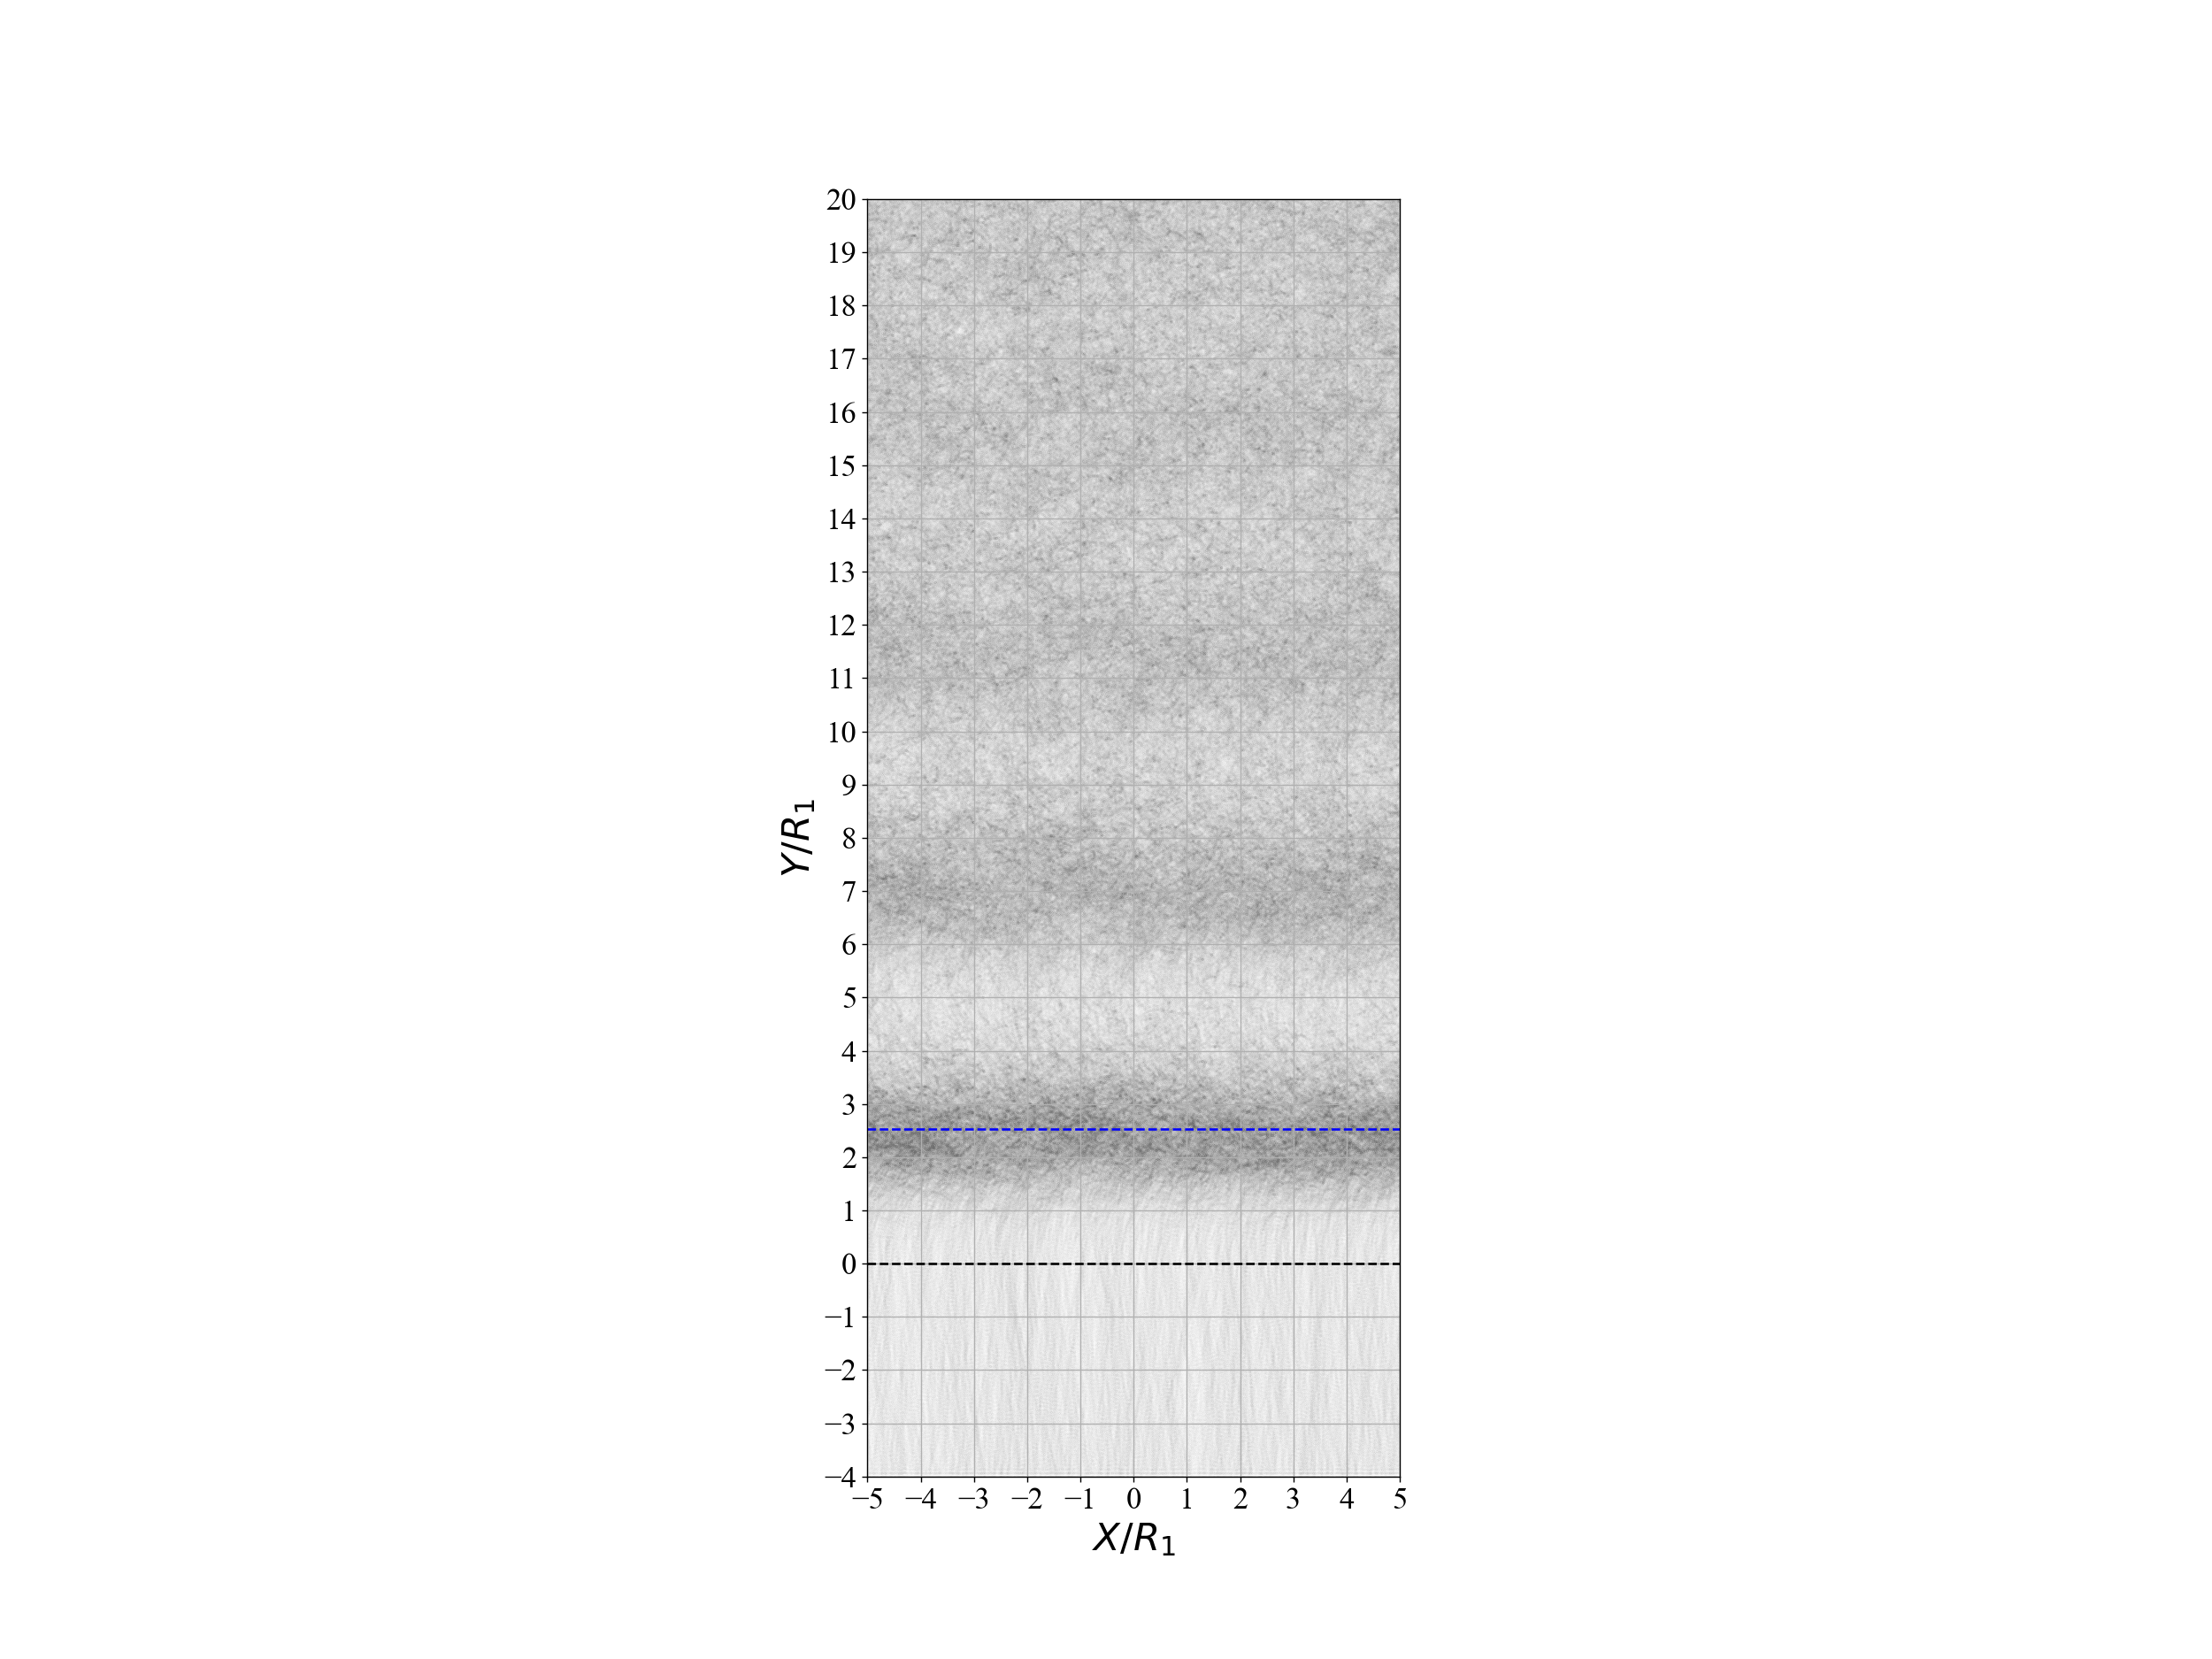

In [36]:
ynlim = 1000
y0 = -4.0*R1 

nstep=10

fig,ax = plt.subplots(1,1,figsize=(20,15))

ax.scatter(rx[:ynlim,0:50000:nstep]/R1,ry[:ynlim,0:50000:nstep]/R1,s=0.00002, color='k')

for i in range(0,1):
    
    ax.axhline(y= (1/2+i)*y_p, color='blue', linestyle='--')
    #ax.scatter(rx[:ynlim,200*i]/R1  , ry[:ynlim,200*i]/R1,s= 1 ,marker='.')

ax.axhline(y=0.0, color='k', linestyle='--')

ax.set_ylim([-4,20]);  #[y0/R1,100.5]
ax.set_xlim([-5,5])

ax.set_xticks(np.arange(-5,5.1,1))

ax.set_yticks(np.arange(-4,20.1,1))

ax.set_xlabel(r'$X/R_1$',size=25);ax.set_ylabel(r'$Y/R_1$',size= 25)
ax.tick_params(axis='both', which='major', labelsize = 20 )
ax.grid(axis='both')

ax.set_aspect(1)


plt.savefig('MonteCarlo07102015_2D_v1.png',dpi=150, bbox_inches='tight',facecolor='w', edgecolor='w')

#plt.savefig('MonteCarlo07102015_2D.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')
#plt.savefig('MonteCarlo07102015_2D_v2.png', bbox_inches='tight',facecolor='w', edgecolor='w')
#plt.savefig('MonteCarlo07102015_2D_v4.png', bbox_inches='tight',dpi=150, facecolor='w', edgecolor='w')

## Discretização 

In [36]:
R1

57723.69214019554

In [37]:
# Ajuste do tamanho dos vetores posição (rx e ry) para realizar a descritização dentro de uma faixa especifica.
rx_d = rx[:ynlim,:]; ry_d = ry[:ynlim,:]

rx_d.shape, ry_d.shape

((1000, 50000), (1000, 50000))

In [38]:
# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10

# Limites em x e y x0lower = -5.0 x0upper = 5.0   
x_1 = -5 ;  y_1 = -4
x_2 =  5 ;  y_2 = 20
 
# Definição das regiões pré-choque e pós-choque
i_up = int((0-y_1)/dy)          #Construção dos indices para os vetores
i_dw = int((y_2-y_1)/dy)

# Discretização 
x_i = int((x_2-x_1)/dx)
y_i = int((y_2-y_1)/dy)

rx_d = rx/R1; ry_d = ry/R1
    
#Cálculo das densidades numéricas    
cc   = np.zeros((x_i, y_i))
c_vx = np.zeros((x_i, y_i))
c_vy = np.zeros((x_i, y_i))

x_size = np.arange(len(rx_d))
y_size = np.arange(len(rx_d[0,:]))

x_ii = np.arange(x_1, x_2, dx)
y_jj = np.arange(y_1, y_2, dy)

for i in x_size:
    
    for j in y_size:
        
        for k in x_ii:
            
            if k <rx_d[i,j]< k + dx:
                
                for l in y_jj:
                    
                    if l < ry_d[i,j] < l+dy:
                        
                        cc[round((k-x_1)/dx),   round((l-y_1)/dy)]  += 1
                        c_vx[round((k-x_1)/dx), round((l-y_1)/dx)]  += vx[i,j]
                        c_vy[round((k-x_1)/dy), round((l-y_1)/dy)]  += vy[i,j]
                        
                        break
                break
                
cm_vx = c_vx/cc; cm_vy = c_vy/cc  # Valores médios
cc_n = cc/np.max(cc)  
    
#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2)

w_i = (n1*1e6*v1n)/((cc*cm_v)/(dx*R1*dy*R1))  
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1)
    
aa = np.mean(Z_d[:][0:i_up])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vy.T 

### Salvamento 

In [39]:
#path_in+'boris2D\\Extensao\\ ; path_in+'boris2D\\'+'cc_01.txt'
#path_in+'boris2D\\Extensao_100

#np.savetxt(path_in+'2D\\'+'cc_skp1_20.txt', cc); 
#np.savetxt(path_in+'2D\\'+'w_i_skp1_20.txt', w_i) 
#np.savetxt(path_in+'2D\\'+'cvx_skp1_20.txt', cm_vx)
#np.savetxt(path_in+'2D\\'+'cvy_skp1_20.txt', cm_vy)

### Carregamento 

In [22]:
cc    = np.loadtxt(path_in+'2D\\'+'cc_skp1_20.txt')
w_i   = np.loadtxt(path_in+'2D\\'+'w_i_skp1_20.txt') 
cm_vx = np.loadtxt(path_in+'2D\\'+'cvx_skp1_20.txt')
cm_vy = np.loadtxt(path_in+'2D\\'+'cvy_skp1_20.txt')

# Definição dos parâmetros de simulação
dx = 0.10
dy = 0.10

# Limites em x e y x0lower = -5.0 x0upper = 5.0 
x_1 = -5 ;  y_1 = -4
x_2 =  5 ;  y_2 = 20     
 
# Definição das regiões pré-choque e pós-choque
i_up = int((0-y_1)/dy)          #Construção dos indices para os vetores
i_dw = int((y_2-y_1)/dy)

#Cálculo dos pesos    
cm_v = np.sqrt(cm_vx**2+cm_vy**2)
cc_n = cc/np.max(cc) 
    
# Densidade     
Z_d = w_i.T*cc.T/(dx*R1*dy*R1)
    
aa = np.mean(Z_d[:][0:i_up+1])/1e6       # Valor médio da densidade na região pré-choque
bb = np.mean(Z_d[:][i_up+1:i_dw])/1e6    # Valor médio da densidade na região pós-choque 
    
#Fluxo em X    
F_X = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vx.T  
    
#Fluxo em Y   
F_Y = (w_i.T*cc.T/(dx*R1*dy*R1))*cm_vy.T 

# Contas

In [23]:
f11 = np.mean(F_X[:][0:i_up])/1e11
f12 = np.mean(F_X[:][i_up:])/1e11 

f21 = np.mean(F_Y[:][0:i_up])/1e11
f22 = np.mean(F_Y[:][i_up:])/1e11 

F_1 = np.sqrt(f11**2+f21**2)
F_2 = np.sqrt(f12**2+f22**2)

n_1 = (aa*1e6)
n_2 = (bb*1e6)

v_1 = (F_1*1e11)/n_1 
v_2 = (F_2*1e11)/n_2

np.shape(F_X[:][0:i_up]), np.shape(F_X[:][i_up:i_dw]), f11, f12, f21, f22, v_1, v_2, aa, bb/aa

((40, 100),
 (200, 100),
 -0.9580010824134155,
 0.8481069372435436,
 83.08956699549441,
 82.67698483373897,
 381904.0304933746,
 166710.91082425267,
 21.75810751622353,
 2.279409405259747)

In [24]:
Fx = pd.DataFrame(F_X,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
Fy = pd.DataFrame(F_Y,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))

Fx = Fx.T/1e11
Fy = Fy.T/1e11

Fx

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,0.429299,-0.375497,-0.645879,-0.557185,-0.571258,0.482610,0.165545,0.452150,0.134576,0.108975,...,-1.533990,-1.119748,2.823956,6.113587,4.971724,4.253537,-1.179661,0.659095,7.759834,4.496736
-4.85,0.374808,0.897232,0.879401,0.700987,0.461027,-0.822844,-1.108638,-1.183453,-1.059464,-0.832920,...,0.866108,0.940517,-0.543564,5.366391,8.671505,3.480822,-1.372884,3.083679,0.695603,8.863118
-4.75,-1.055625,-1.137471,-1.407295,-1.945904,-1.800342,-0.552969,-0.594301,-0.765910,-1.056860,-0.451804,...,4.167988,2.529009,3.030516,1.988685,4.351158,2.462035,3.773333,0.981226,4.768337,2.590982
-4.65,-0.154458,-0.028986,-0.856573,-1.017233,-1.848452,-1.611201,-1.556112,-0.690957,-0.674839,-1.030657,...,1.548546,5.833043,3.325784,3.429100,-0.774400,-0.976228,4.406016,2.270290,4.720295,0.709250
-4.55,-1.271867,-0.836615,-1.286200,-0.226699,-0.243623,0.108356,-0.866489,-0.969580,-1.241306,-1.904925,...,1.302200,5.397617,10.526932,2.918066,-6.861985,3.388191,1.242790,4.458887,3.045829,2.035257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.095121,-0.122098,-0.105375,-0.483444,-0.181477,0.184733,0.458970,0.258773,-0.140886,-0.245281,...,-0.998008,2.836617,-1.982925,-0.075259,-2.148101,-1.109100,3.774588,0.884991,3.898676,-2.659473
4.65,0.575014,0.890560,1.064192,0.629797,0.223688,-0.207993,-0.607400,-0.533762,-0.018861,-0.589474,...,-2.793842,-4.052252,-2.029380,-2.524661,-1.091845,4.177173,1.415157,2.140244,2.655592,-0.580483
4.75,-0.004509,-0.556910,-0.448688,-0.740925,0.063794,0.227520,0.559631,-0.275518,0.192324,-0.038364,...,-3.222418,-4.509018,0.111304,-3.042352,3.233186,2.999125,0.850559,4.448910,1.524290,4.025557
4.85,-0.643418,-0.687191,-0.413008,-0.306647,-0.993939,-0.730614,-0.074582,0.137890,0.004828,-0.181332,...,-3.377072,-1.874807,2.295638,-0.205249,1.692954,5.074628,1.170581,5.043599,7.350120,0.369876


In [25]:
Fy

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,83.098096,83.098357,83.096695,83.097337,83.097242,83.097804,83.099040,83.097975,83.099096,83.099134,...,83.085046,83.091661,83.051208,82.874013,82.950346,82.990273,83.090832,83.096592,82.736104,82.977451
-4.85,83.098360,83.094361,83.094552,83.096249,83.097926,83.095131,83.091810,83.090778,83.092451,83.095031,...,83.094692,83.093883,83.097428,82.925749,82.645526,83.026272,83.087864,83.041970,83.096294,82.625196
-4.75,83.092500,83.091420,83.087288,83.076419,83.079701,83.097365,83.097080,83.095676,83.092484,83.097977,...,82.994613,83.060713,83.043928,83.075406,82.985212,83.062725,83.013492,83.093412,82.962286,83.058803
-4.65,83.099062,83.099200,83.094791,83.092979,83.078644,83.083584,83.084634,83.096333,83.096465,83.092814,...,83.084776,82.894231,83.032627,83.028424,83.095597,83.093471,82.982317,83.068187,82.965033,83.096179
-4.55,83.089472,83.094994,83.089251,83.098896,83.098848,83.099135,83.094688,83.093549,83.089934,83.077369,...,83.089002,82.923722,82.429738,83.047955,82.815404,83.030103,83.089912,82.979493,83.043367,83.074278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,83.099151,83.099116,83.099139,83.097799,83.099007,83.099000,83.097938,83.098802,83.099086,83.098843,...,83.093212,83.050777,83.075544,83.099171,83.071437,83.091804,83.013435,83.094493,83.007700,83.056638
4.65,83.097216,83.094433,83.092391,83.096819,83.098904,83.098945,83.096985,83.097491,83.099203,83.097115,...,83.052227,83.000344,83.074422,83.060845,83.092032,82.994151,83.087155,83.071639,83.056762,83.097178
4.75,83.099205,83.097339,83.097994,83.095902,83.099181,83.098894,83.097321,83.098749,83.098983,83.099196,...,83.036702,82.976784,83.099131,83.043495,83.036284,83.045067,83.094852,82.980028,83.085224,83.001643
4.85,83.096714,83.096364,83.098179,83.098640,83.093261,83.095993,83.099172,83.099091,83.099205,83.099007,...,83.030557,83.078054,83.067490,83.098952,83.081959,82.944114,83.090960,82.946007,82.773508,83.098382


<IPython.core.display.Javascript object>


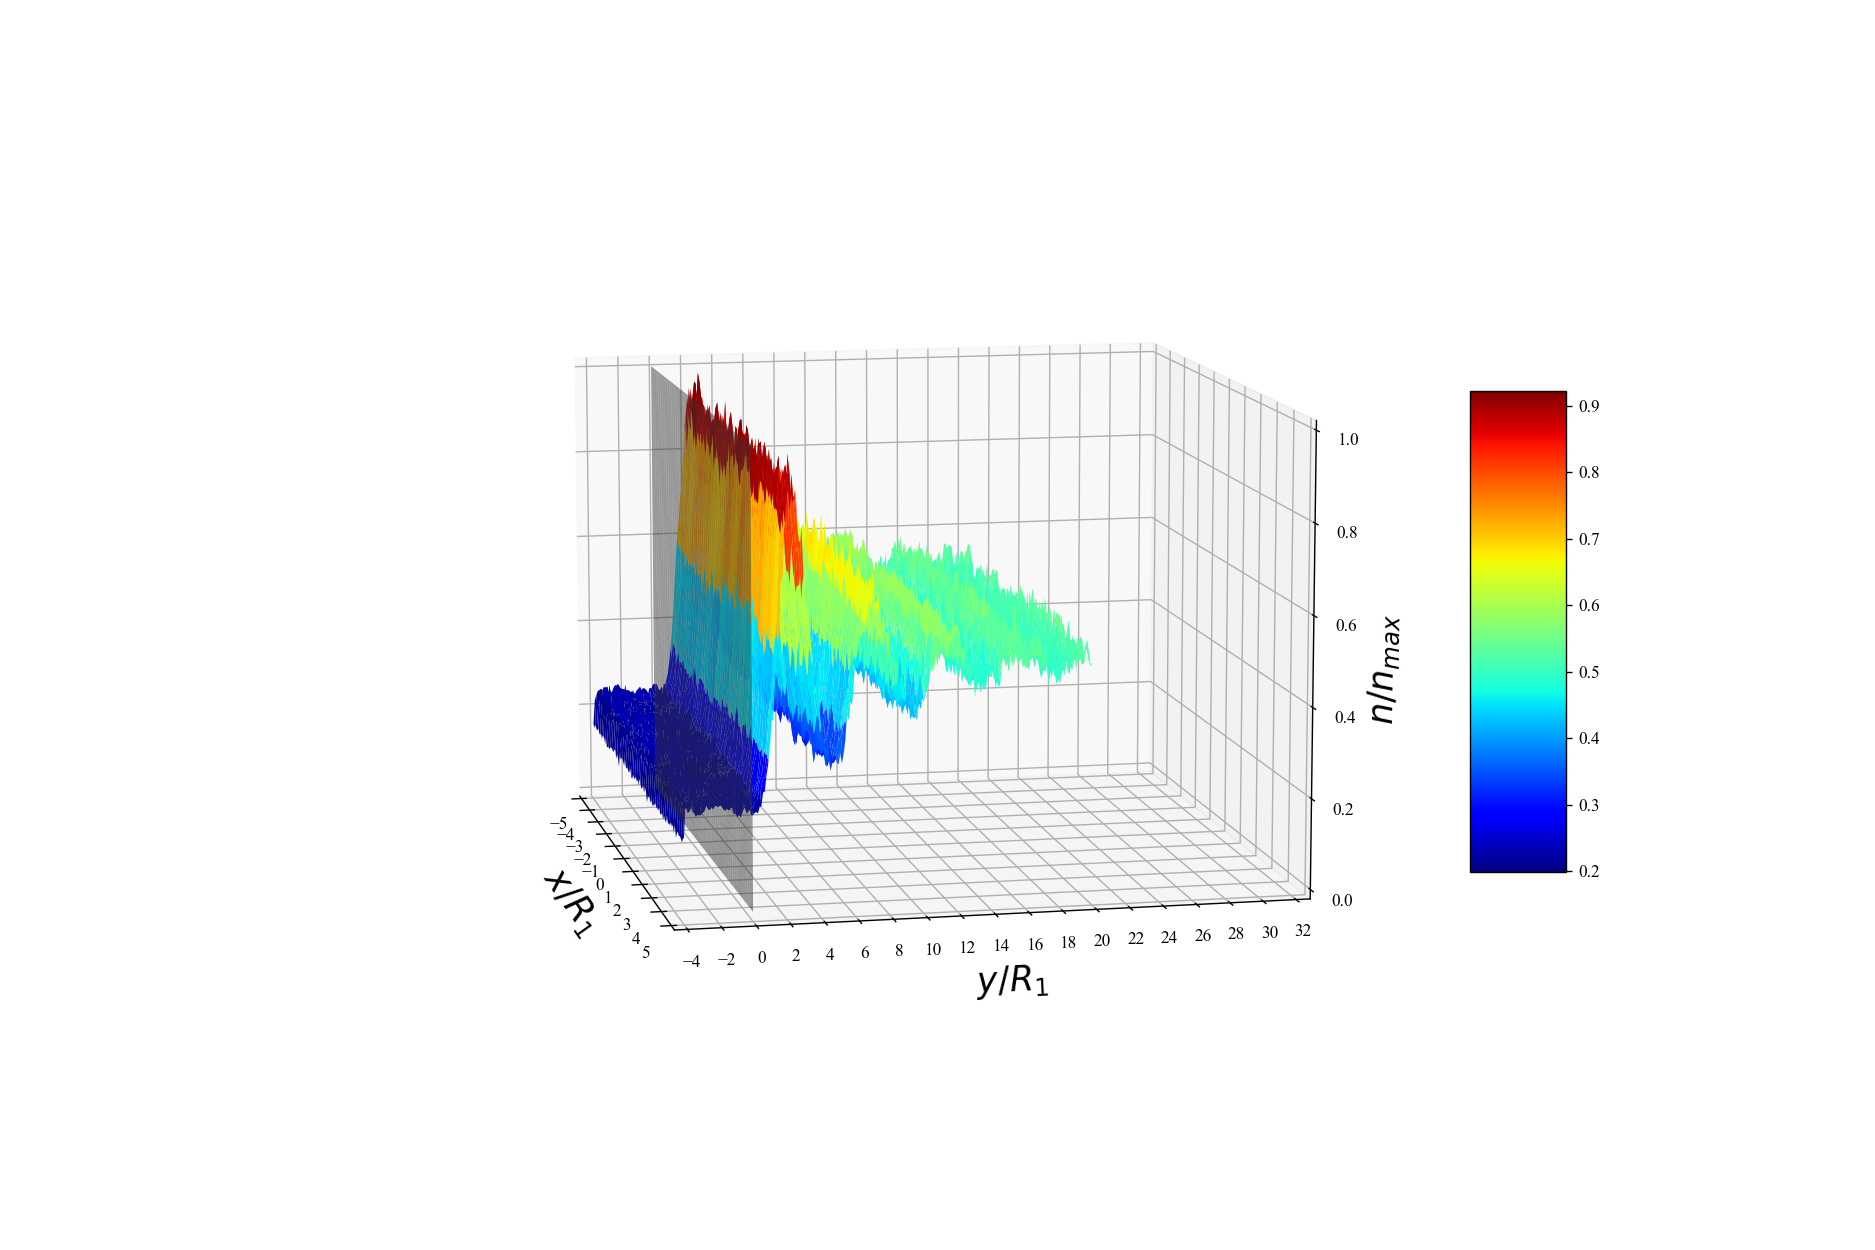

In [26]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(15,10))

# Make data.

X = np.arange(-5+dx/2,5,dx)
Y = np.arange(-4+dy/2,20.,dy)

X, Y = np.meshgrid(X, Y)

Z = cc_n.T   #Usando transposta


# Plot the surface.
surf = ax.plot_surface(X, Y, Z , cmap='jet')

z_p, x_p = np.meshgrid(np.linspace(0,1,100),np.linspace(-5,5, 100))

y_p = x_p*0

ax.plot_surface(x_p, y_p, z_p, color= "gray", alpha=0.5)  # the vertical plane

ax.set_xlabel(r'$x/R_1$',size=20)
ax.set_ylabel(r'$y/R_1$',size=20, labelpad=10)
ax.set_zlabel(r'$n/n_{max}$',size=20)

ax.set_xlim([-4.9,5.1])
ax.set_ylim([-3.9,32.1])

ax.set_xticks(np.arange(-5,5.1,1))
ax.set_yticks(np.arange(-4,32.1,2))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

ax.view_init(10, -12)

#plt.savefig(path_in+'boris2D\\Extensao\\Densidade númerica_50000_particles_01.png',
#dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

In [27]:
#cm = plt.cm.get_cmap('Greys')
#np.max(Z_d)/1e6 , np.min(Z_d)/1e6

### Estimativa dos erros

In [28]:
cc_td =  pd.DataFrame(cc,  index =np.arange(x_1+dx/2,x_2,dx) , columns = np.arange(y_1+dy/2,y_2,dy))
cc_td

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,536.0,721.0,764.0,722.0,775.0,744.0,794.0,789.0,828.0,807.0,...,1837.0,1718.0,1777.0,1826.0,1703.0,1659.0,1815.0,1702.0,1703.0,1714.0
-4.85,507.0,734.0,815.0,787.0,846.0,802.0,852.0,818.0,806.0,796.0,...,1814.0,1723.0,1682.0,1654.0,1741.0,1750.0,1747.0,1805.0,1767.0,1660.0
-4.75,543.0,773.0,811.0,819.0,827.0,816.0,842.0,832.0,845.0,802.0,...,1879.0,1633.0,1518.0,1557.0,1633.0,1810.0,1793.0,1711.0,1738.0,1768.0
-4.65,533.0,746.0,756.0,718.0,726.0,704.0,709.0,740.0,751.0,755.0,...,1871.0,1741.0,1636.0,1556.0,1825.0,1752.0,1810.0,1843.0,1711.0,1806.0
-4.55,519.0,711.0,749.0,752.0,728.0,724.0,715.0,700.0,692.0,695.0,...,1869.0,1738.0,1713.0,1705.0,1778.0,1739.0,1842.0,1838.0,1747.0,1682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,533.0,733.0,775.0,742.0,763.0,768.0,750.0,764.0,778.0,754.0,...,1654.0,1841.0,1946.0,1777.0,1810.0,1762.0,1773.0,1754.0,1760.0,1760.0
4.65,522.0,725.0,803.0,760.0,774.0,756.0,775.0,738.0,721.0,752.0,...,1634.0,1720.0,1770.0,1862.0,1846.0,1874.0,1755.0,1696.0,1774.0,1816.0
4.75,504.0,756.0,777.0,809.0,795.0,827.0,809.0,818.0,839.0,785.0,...,1799.0,1751.0,1840.0,1753.0,1867.0,1852.0,1748.0,1799.0,1753.0,1703.0
4.85,542.0,746.0,768.0,727.0,742.0,771.0,738.0,759.0,776.0,799.0,...,1724.0,1759.0,1758.0,1748.0,1684.0,1695.0,1814.0,1863.0,1778.0,1671.0


### Contagem de partículas na região pré-choque

In [29]:
cc_up = pd.DataFrame(cc[:,0:i_up], index = np.arange(x_1+dx/2,x_2,dx) , columns = np.arange(y_1+dy/2,0,dy) ) 
cc_up

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,536.0,721.0,764.0,722.0,775.0,744.0,794.0,789.0,828.0,807.0,...,761.0,757.0,788.0,790.0,762.0,730.0,793.0,768.0,817.0,837.0
-4.85,507.0,734.0,815.0,787.0,846.0,802.0,852.0,818.0,806.0,796.0,...,795.0,834.0,801.0,824.0,808.0,781.0,771.0,767.0,757.0,791.0
-4.75,543.0,773.0,811.0,819.0,827.0,816.0,842.0,832.0,845.0,802.0,...,805.0,782.0,774.0,760.0,760.0,814.0,819.0,811.0,758.0,769.0
-4.65,533.0,746.0,756.0,718.0,726.0,704.0,709.0,740.0,751.0,755.0,...,769.0,769.0,816.0,835.0,817.0,812.0,816.0,820.0,812.0,811.0
-4.55,519.0,711.0,749.0,752.0,728.0,724.0,715.0,700.0,692.0,695.0,...,837.0,832.0,819.0,798.0,805.0,766.0,776.0,758.0,785.0,790.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,533.0,733.0,775.0,742.0,763.0,768.0,750.0,764.0,778.0,754.0,...,833.0,778.0,832.0,834.0,876.0,863.0,895.0,843.0,837.0,833.0
4.65,522.0,725.0,803.0,760.0,774.0,756.0,775.0,738.0,721.0,752.0,...,768.0,774.0,776.0,737.0,751.0,739.0,761.0,732.0,789.0,792.0
4.75,504.0,756.0,777.0,809.0,795.0,827.0,809.0,818.0,839.0,785.0,...,713.0,756.0,706.0,692.0,713.0,722.0,734.0,760.0,748.0,747.0
4.85,542.0,746.0,768.0,727.0,742.0,771.0,738.0,759.0,776.0,799.0,...,791.0,814.0,785.0,814.0,793.0,756.0,754.0,706.0,719.0,734.0


### Contagem de partículas na região pós-choque 

In [30]:
cc_dw = pd.DataFrame(cc[:,i_up:], index = np.arange(x_1+dx/2,x_2,dx) , columns = np.arange(0+dy/2,y_2,dy) ) 
cc_dw

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,830.0,832.0,790.0,783.0,811.0,777.0,796.0,860.0,881.0,989.0,...,1837.0,1718.0,1777.0,1826.0,1703.0,1659.0,1815.0,1702.0,1703.0,1714.0
-4.85,743.0,805.0,790.0,849.0,870.0,843.0,903.0,922.0,892.0,965.0,...,1814.0,1723.0,1682.0,1654.0,1741.0,1750.0,1747.0,1805.0,1767.0,1660.0
-4.75,743.0,723.0,724.0,762.0,819.0,837.0,879.0,927.0,1029.0,1038.0,...,1879.0,1633.0,1518.0,1557.0,1633.0,1810.0,1793.0,1711.0,1738.0,1768.0
-4.65,815.0,825.0,874.0,860.0,806.0,856.0,894.0,926.0,969.0,1098.0,...,1871.0,1741.0,1636.0,1556.0,1825.0,1752.0,1810.0,1843.0,1711.0,1806.0
-4.55,814.0,795.0,789.0,821.0,833.0,873.0,883.0,883.0,947.0,1025.0,...,1869.0,1738.0,1713.0,1705.0,1778.0,1739.0,1842.0,1838.0,1747.0,1682.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,830.0,812.0,813.0,819.0,827.0,851.0,880.0,894.0,947.0,1054.0,...,1654.0,1841.0,1946.0,1777.0,1810.0,1762.0,1773.0,1754.0,1760.0,1760.0
4.65,792.0,831.0,818.0,799.0,837.0,851.0,920.0,956.0,1008.0,1011.0,...,1634.0,1720.0,1770.0,1862.0,1846.0,1874.0,1755.0,1696.0,1774.0,1816.0
4.75,762.0,737.0,755.0,786.0,803.0,797.0,826.0,856.0,972.0,1040.0,...,1799.0,1751.0,1840.0,1753.0,1867.0,1852.0,1748.0,1799.0,1753.0,1703.0
4.85,738.0,748.0,794.0,787.0,844.0,844.0,919.0,957.0,960.0,1057.0,...,1724.0,1759.0,1758.0,1748.0,1684.0,1695.0,1814.0,1863.0,1778.0,1671.0


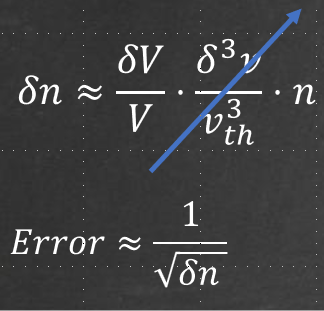

In [31]:
DLLn1 = ( (dx*dy)/(i_up) )*np.sum(cc[:,0:i_up])
DLLn2 = ( (dx*dy)/(i_dw-i_up) )*np.sum(cc[:,i_up:])

dln1 = 1/np.sqrt(DLLn1)
dln2 = 1/np.sqrt(DLLn2)

dln1, dln2

(0.03652783121016324, 0.024067770674654224)

In [32]:
Z = w_i.T*cc.T/(dx*R1*dy*R1)   #Usando transposta

n_massa = pd.DataFrame(Z,  columns=np.arange(x_1+dx/2,x_2,dx) , index = np.arange(y_1+dy/2,y_2,dy))
n_mass  = n_massa.T

n_mass = n_mass/1e6

In [33]:
n_mass

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,21.367514,22.164224,21.702116,21.553344,21.589130,21.673077,21.698440,21.814879,21.835355,21.706590,...,53.048515,51.362320,48.705073,49.969046,50.263782,53.996383,53.696068,52.945894,50.300662,47.813545
-4.85,21.628937,22.265077,21.861121,21.854200,21.918721,21.993208,21.917644,21.933491,21.961223,21.846122,...,51.348058,51.209130,51.189095,49.525838,47.247407,50.684197,52.129706,49.949808,48.946113,49.388235
-4.75,21.691731,22.321263,21.926822,21.956090,22.037881,21.969322,21.708768,21.845849,21.882929,21.822351,...,54.137842,47.150512,46.032898,48.573235,49.365262,48.195931,50.515934,52.620888,55.070886,52.704022
-4.65,21.398190,22.184355,21.791606,21.549300,21.700902,21.757575,21.530349,21.712602,21.745895,21.643932,...,51.098592,47.857475,45.782773,47.594580,52.676912,49.868133,48.719940,49.117570,46.868910,49.715851
-4.55,21.711168,22.202874,21.607213,21.717143,21.690512,21.690316,21.813164,21.766967,21.753078,21.799846,...,51.435975,47.832278,48.327329,47.202342,48.611266,48.269534,50.160289,51.520739,47.060049,47.511199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,21.414436,22.224795,21.662436,21.573556,21.624180,21.602148,21.740613,21.690190,21.666863,21.724566,...,44.062824,46.006747,48.520727,47.001866,44.191047,45.069450,47.815098,48.459878,49.188421,49.463437
4.65,21.475554,22.049368,21.809866,21.840602,21.932642,21.964228,21.957456,21.956968,21.960579,22.136446,...,48.431450,47.332424,48.495496,48.807502,50.770050,50.749467,50.689600,47.626299,46.857380,47.361059
4.75,21.852213,22.568476,22.076057,21.982140,21.888838,21.776678,21.918659,21.854959,21.744011,21.740885,...,47.219259,49.851656,50.510661,50.715586,54.924565,53.003477,49.676634,52.421756,53.696429,52.865611
4.85,21.616307,22.204256,21.620678,21.793062,21.942238,22.031183,22.056914,22.137945,22.129790,22.244049,...,47.499680,49.189556,52.733872,51.895323,48.377511,52.205878,52.749526,54.864161,52.038925,50.644245


In [34]:
n_mass[n_mass.columns[0:40]]

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,21.367514,22.164224,21.702116,21.553344,21.589130,21.673077,21.698440,21.814879,21.835355,21.706590,...,21.634920,21.676489,21.772017,21.678249,21.517796,21.610299,21.695813,21.652052,21.720254,21.672276
-4.85,21.628937,22.265077,21.861121,21.854200,21.918721,21.993208,21.917644,21.933491,21.961223,21.846122,...,21.853284,21.628613,21.611610,21.728592,21.613186,21.705207,21.535172,21.629648,21.474790,21.550010
-4.75,21.691731,22.321263,21.926822,21.956090,22.037881,21.969322,21.708768,21.845849,21.882929,21.822351,...,22.019320,22.106072,21.943870,21.844018,21.967652,21.931204,22.061847,21.937034,21.910103,21.905732
-4.65,21.398190,22.184355,21.791606,21.549300,21.700902,21.757575,21.530349,21.712602,21.745895,21.643932,...,21.615867,21.706356,21.788055,21.893198,21.803855,21.830378,21.629057,21.713283,21.588662,21.532414
-4.55,21.711168,22.202874,21.607213,21.717143,21.690512,21.690316,21.813164,21.766967,21.753078,21.799846,...,21.436360,21.341279,21.324339,21.419944,21.328520,21.391406,21.380264,21.561505,21.539256,21.642914
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,21.414436,22.224795,21.662436,21.573556,21.624180,21.602148,21.740613,21.690190,21.666863,21.724566,...,21.680921,21.633517,21.581001,21.669448,21.653604,21.709930,21.659936,21.628480,21.595022,21.552235
4.65,21.475554,22.049368,21.809866,21.840602,21.932642,21.964228,21.957456,21.956968,21.960579,22.136446,...,21.920992,21.731943,21.856966,21.774468,21.653828,21.502811,21.500829,21.632718,21.650402,21.709629
4.75,21.852213,22.568476,22.076057,21.982140,21.888838,21.776678,21.918659,21.854959,21.744011,21.740885,...,21.626675,21.544143,21.656172,21.434772,21.522780,21.488471,21.433861,21.281410,21.392076,21.332086
4.85,21.616307,22.204256,21.620678,21.793062,21.942238,22.031183,22.056914,22.137945,22.129790,22.244049,...,21.735316,21.648424,21.695355,21.680718,21.662797,21.449776,21.702688,21.696747,21.729697,21.773054


In [35]:
n_mass.describe()

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,21.612558,22.256924,21.824507,21.832348,21.848357,21.836457,21.839972,21.838941,21.838144,21.826013,...,49.471754,49.463132,49.654043,49.846277,50.266195,50.078790,50.529654,50.600056,50.772156,50.990579
std,0.192641,0.169901,0.178570,0.175592,0.182813,0.175119,0.184021,0.194644,0.196896,0.170867,...,2.424194,2.158099,2.129982,2.153149,2.582133,2.357659,2.091740,2.537465,2.683006,2.527814
min,21.148790,21.901317,21.450964,21.460983,21.501317,21.490090,21.437640,21.335149,21.360645,21.416855,...,43.306710,45.316549,45.782773,44.919241,44.191047,45.069450,46.359312,43.463481,45.076868,45.125519
25%,21.467666,22.145135,21.692650,21.716077,21.711005,21.716416,21.716946,21.720561,21.700570,21.718782,...,48.102362,47.953756,48.130830,48.346386,48.958611,48.264868,49.040487,48.832859,49.136401,49.350374
50%,21.622622,22.258373,21.808289,21.817424,21.850998,21.821239,21.843114,21.826563,21.832720,21.821718,...,49.516186,49.067960,49.395601,49.697869,50.096905,50.468578,50.434990,50.880525,50.583857,51.415425
75%,21.720029,22.352193,21.945411,21.942232,21.945084,21.966418,21.965314,21.953897,21.961727,21.920604,...,50.751024,51.032273,51.154684,51.627485,51.707463,51.571916,51.773338,52.607646,52.382846,52.781068
max,22.022728,22.707033,22.329984,22.405372,22.457817,22.415936,22.331413,22.463620,22.374573,22.316936,...,56.174666,55.623060,55.309086,55.106897,55.947803,55.347738,56.570169,55.992308,57.291232,56.525917


In [36]:
#Número de partículas na região pré e pós choque.

np.sum(cc[:,0:i_up]), np.sum(cc[:,i_up:])

(2997866.0, 34526954.0)

In [37]:
d_up = np.mean(np.mean(n_mass[n_mass.columns[0:i_up]]))
d_dw = np.mean(np.mean(n_mass[n_mass.columns[i_up:]]))

d_up, d_dw

(21.76085069956525, 49.4558986394798)

In [38]:
nsig_up = n_mass[n_mass.columns[0:i_up]]*dln1   # dln1 é o erro percentual estimado para cada bin na região pré-choque
nsig_dw = n_mass[n_mass.columns[i_up:]] *dln2   # dln2 é o erro percentual estimado para cada bin na região pós-choque

In [39]:
nsig_up

,-3.95,-3.85,-3.75,-3.65,-3.55,-3.45,-3.35,-3.25,-3.15,-3.05,...,-0.95,-0.85,-0.75,-0.65,-0.55,-0.45,-0.35,-0.25,-0.15,-0.05
-4.95,0.780509,0.809611,0.792731,0.787297,0.788604,0.791670,0.792597,0.796850,0.797598,0.792895,...,0.790277,0.791795,0.795285,0.791859,0.785998,0.789377,0.792501,0.790902,0.793394,0.791641
-4.85,0.790058,0.813295,0.798539,0.798287,0.800643,0.803364,0.800604,0.801183,0.802196,0.797991,...,0.798253,0.790046,0.789425,0.793698,0.789483,0.792844,0.786633,0.790084,0.784428,0.787175
-4.75,0.792352,0.815347,0.800939,0.802008,0.804996,0.802492,0.792974,0.797981,0.799336,0.797123,...,0.804318,0.807487,0.801562,0.797915,0.802431,0.801099,0.805871,0.801312,0.800329,0.800169
-4.65,0.781629,0.810346,0.796000,0.787149,0.792687,0.794757,0.786457,0.793114,0.794330,0.790606,...,0.789581,0.792886,0.795870,0.799711,0.796448,0.797416,0.790063,0.793139,0.788587,0.786532
-4.55,0.793062,0.811023,0.789265,0.793280,0.792307,0.792300,0.796788,0.795100,0.794593,0.796301,...,0.783024,0.779551,0.778932,0.782424,0.779085,0.781382,0.780975,0.787595,0.786782,0.790569
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.782223,0.811824,0.791282,0.788035,0.789884,0.789080,0.794137,0.792296,0.791444,0.793551,...,0.791957,0.790225,0.788307,0.791538,0.790959,0.793017,0.791190,0.790041,0.788819,0.787256
4.65,0.784455,0.805416,0.796667,0.797790,0.801152,0.802306,0.802058,0.802040,0.802172,0.808596,...,0.800726,0.793821,0.798388,0.795374,0.790967,0.785451,0.785379,0.790196,0.790842,0.793006
4.75,0.798214,0.824377,0.806390,0.802960,0.799552,0.795455,0.800641,0.798314,0.794262,0.794147,...,0.789976,0.786961,0.791053,0.782966,0.786180,0.784927,0.782932,0.777364,0.781406,0.779215
4.85,0.789597,0.811073,0.789756,0.796053,0.801502,0.804751,0.805691,0.808651,0.808353,0.812527,...,0.793944,0.790770,0.792484,0.791950,0.791295,0.783514,0.792752,0.792535,0.793739,0.795322


In [40]:
nsig_dw

,0.05,0.15,0.25,0.35,0.45,0.55,0.65,0.75,0.85,0.95,...,19.05,19.15,19.25,19.35,19.45,19.55,19.65,19.75,19.85,19.95
-4.95,0.522952,0.516267,0.525161,0.542532,0.549356,0.548421,0.570725,0.629311,0.637167,0.660059,...,1.276760,1.236177,1.172223,1.202644,1.209737,1.299573,1.292345,1.274290,1.210625,1.150765
-4.85,0.522543,0.523301,0.527800,0.539432,0.554953,0.567343,0.580351,0.619007,0.627930,0.699211,...,1.235833,1.232490,1.232007,1.191977,1.137140,1.219856,1.254646,1.202181,1.178024,1.188665
-4.75,0.531039,0.523933,0.523297,0.534845,0.547654,0.564493,0.570591,0.590006,0.640785,0.671808,...,1.302977,1.134808,1.107909,1.169049,1.188112,1.159969,1.215806,1.266467,1.325433,1.268468
-4.65,0.521644,0.522255,0.529106,0.535752,0.538713,0.562539,0.589057,0.589395,0.627625,0.696506,...,1.229829,1.151823,1.101889,1.145495,1.267816,1.200215,1.172580,1.182150,1.128030,1.196550
-4.55,0.524285,0.522238,0.525929,0.533942,0.544203,0.558938,0.588384,0.633420,0.640744,0.666954,...,1.237949,1.151216,1.163131,1.136055,1.169965,1.161740,1.207246,1.239989,1.132630,1.143489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4.55,0.523603,0.524504,0.531643,0.534290,0.538015,0.549081,0.574438,0.604652,0.618154,0.664174,...,1.060494,1.107280,1.167786,1.131230,1.063580,1.084721,1.150803,1.166321,1.183856,1.190475
4.65,0.524415,0.528287,0.523399,0.538244,0.543102,0.561249,0.571824,0.603392,0.628683,0.664709,...,1.165637,1.139186,1.167178,1.174688,1.221922,1.221427,1.219986,1.146259,1.127753,1.139875
4.75,0.520189,0.516654,0.525607,0.524786,0.534082,0.552559,0.589478,0.584688,0.651769,0.674071,...,1.136462,1.199818,1.215679,1.220611,1.321912,1.275676,1.195606,1.261675,1.292353,1.272357
4.85,0.523147,0.533488,0.528560,0.523037,0.545395,0.550199,0.576153,0.608227,0.626247,0.702129,...,1.143211,1.183883,1.269187,1.249005,1.164339,1.256479,1.269563,1.320458,1.252461,1.218894


In [41]:
np.sum(np.abs(nsig_up))

-3.95    78.945988
-3.85    81.299716
-3.75    79.720192
-3.65    79.748834
-3.55    79.807309
-3.45    79.763841
-3.35    79.776682
-3.25    79.772916
-3.15    79.770002
-3.05    79.725694
-2.95    79.737186
-2.85    79.709397
-2.75    79.713635
-2.65    79.668835
-2.55    79.641448
-2.45    79.681679
-2.35    79.606845
-2.25    79.589704
-2.15    79.572268
-2.05    79.561668
-1.95    79.525076
-1.85    79.517647
-1.75    79.469295
-1.65    79.429700
-1.55    79.399201
-1.45    79.387321
-1.35    79.323947
-1.25    79.325653
-1.15    79.290788
-1.05    79.211644
-0.95    79.219188
-0.85    79.163922
-0.75    79.120528
-0.65    79.107710
-0.55    79.080568
-0.45    79.023876
-0.35    79.048394
-0.25    79.041100
-0.15    79.036032
-0.05    78.971297
dtype: float64

In [42]:
np.sum(np.sum(np.abs(nsig_up))), i_up*cc.shape[0]   #Soma dos erros de cada bin na região pré-choque, número de bins na região pré-choque.

(3179.5067253731277, 4000)

In [43]:
err_up = np.sum(np.sum(np.abs(nsig_up)))/(i_up*cc.shape[0])         # Propagação do erro pré-choque para o calculo de uma média
err_dw = np.sum(np.sum(np.abs(nsig_dw)))/((i_dw-i_up)*cc.shape[0])  # Propagação do erro pós-choque

err_up, err_dw

(0.7948766813432819, 1.1902932269639441)

In [44]:
display(Markdown(rf'$n_1: {d_up:5.4}  \pm {err_up:1.3} $'))

$n_1: 21.76  \pm 0.795 $

In [45]:
display(Markdown(rf'$n_2: {d_dw:6.5}  \pm {err_dw:1.3} $'))

$n_2: 49.456  \pm 1.19 $

#### Incerteza na densidade

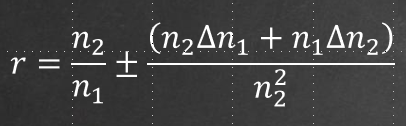

In [46]:
(d_dw*err_up+d_up*err_dw)/((d_dw)**2)

0.02666237763220386

In [47]:
d_up

21.76085069956525

In [48]:
err_up

0.7948766813432819

In [49]:
d_dw

49.4558986394798

In [50]:
deln = (d_dw*err_up+d_up*err_dw)/((d_dw)**2)
deln

0.02666237763220386

#### Incerteza na velocidade 

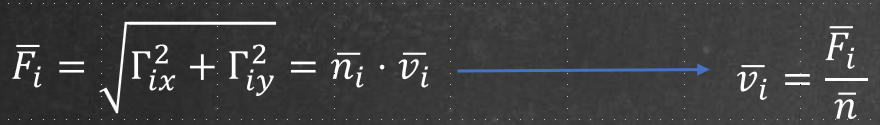

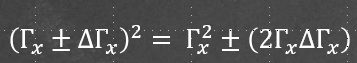

#### Cálculo dos fluxos médios

In [51]:
Fx_up = np.mean(np.mean(Fx[Fx.columns[0:i_up]]))
Fx_dw = np.mean(np.mean(Fx[Fx.columns[i_up:]]))

Fy_up = np.mean(np.mean(Fy[Fy.columns[0:i_up]]))
Fy_dw = np.mean(np.mean(Fy[Fy.columns[i_up:]]))

Fx_up, Fx_dw, Fy_up, Fy_dw

(-0.9580010824134154, 0.8481069372435428, 83.08956699549438, 82.67698483373896)

#### Estimativa das incerteza dos fluxos médios 

In [52]:
nfx_up = Fx[Fx.columns[0:i_up]]*dln1
nfx_dw = Fx[Fx.columns[i_up:]] *dln2

nfy_up = Fy[Fy.columns[0:i_up]]*dln1
nfy_dw = Fy[Fy.columns[i_up:]] *dln2

In [53]:
errfx_up = np.sum(np.sum(np.abs(nfx_up)))/(i_up*cc.shape[0])
errfx_dw = np.sum(np.sum(np.abs(nfx_dw)))/((i_dw-i_up)*cc.shape[0])

errfy_up = np.sum(np.sum(np.abs(nfy_up)))/(i_up*cc.shape[0])
errfy_dw = np.sum(np.sum(np.abs(nfy_dw)))/((i_dw-i_up)*cc.shape[0])

errfx_up, errfx_dw, errfy_up, errfy_dw

(0.038958808420080905,
 0.15714877496484247,
 3.0350816785369696,
 1.9898507110502952)

#### Região pré-choque 

In [54]:
f_upx = Fx_up**2  
f_upy = Fy_up**2

delf_upx =  np.abs(2*Fx_up*errfx_up)
delf_upy =  np.abs(2*Fy_up*errfy_up)

#f_upx,f_upy, delf_upx, delf_upy

f_up    = (f_upx + f_upy)
delf_up = (delf_upx + delf_upy)

F_up    = np.sqrt(f_up)
Delf_up = 0.5*(1/(np.sqrt(f_up)))*delf_up

round(F_up,3), round(Delf_up,3)      # Fluxo médio na região pré-choque mais a incerteza

(83.095, 3.035)

####  Região pós-choque

In [55]:
f_dwx = Fx_dw**2  
f_dwy = Fy_dw**2

delf_dwx =  np.abs(2*Fx_dw*errfx_dw)
delf_dwy =  np.abs(2*Fy_dw*errfy_dw)

#f_upx,f_upy, delf_upx, delf_upy

f_dw    = (f_dwx + f_dwy)
delf_dw = (delf_dwx + delf_dwy)

F_dw    = np.sqrt(f_dw)
Delf_dw = 0.5*(1/(np.sqrt(f_dw)))*delf_dw

round(F_dw,3), round(Delf_dw,3)      # Fluxo médio na região pré-choque mais a incerteza

(82.681, 1.991)

#### Incerteza nas velocidades

In [56]:
v_up    = F_up/d_up
v_dw    = F_dw/d_dw

Del_vup = (F_up*err_up+d_up*Delf_up)/d_up**2
Del_vdw = (F_dw*err_dw+d_dw*Delf_dw)/d_dw**2

round(v_up*1e5,3), round(Del_vup*1e5,3), round(v_dw*1e5,3), round(Del_vdw*1e5,3)

(381855.887, 27896.945, 167181.948, 8050.23)

#### Estimativa do r a partir das velocidades

In [57]:
r_v    = v_up/v_dw
del_rv = (v_up*Del_vdw + v_dw*Del_vup)/v_dw**2

round(r_v, 3), round(del_rv, 3)

(2.284, 0.277)

In [58]:
v_up

3.818558874869705

In [59]:
round(v_up*1e2,3)

381.856

<IPython.core.display.Javascript object>


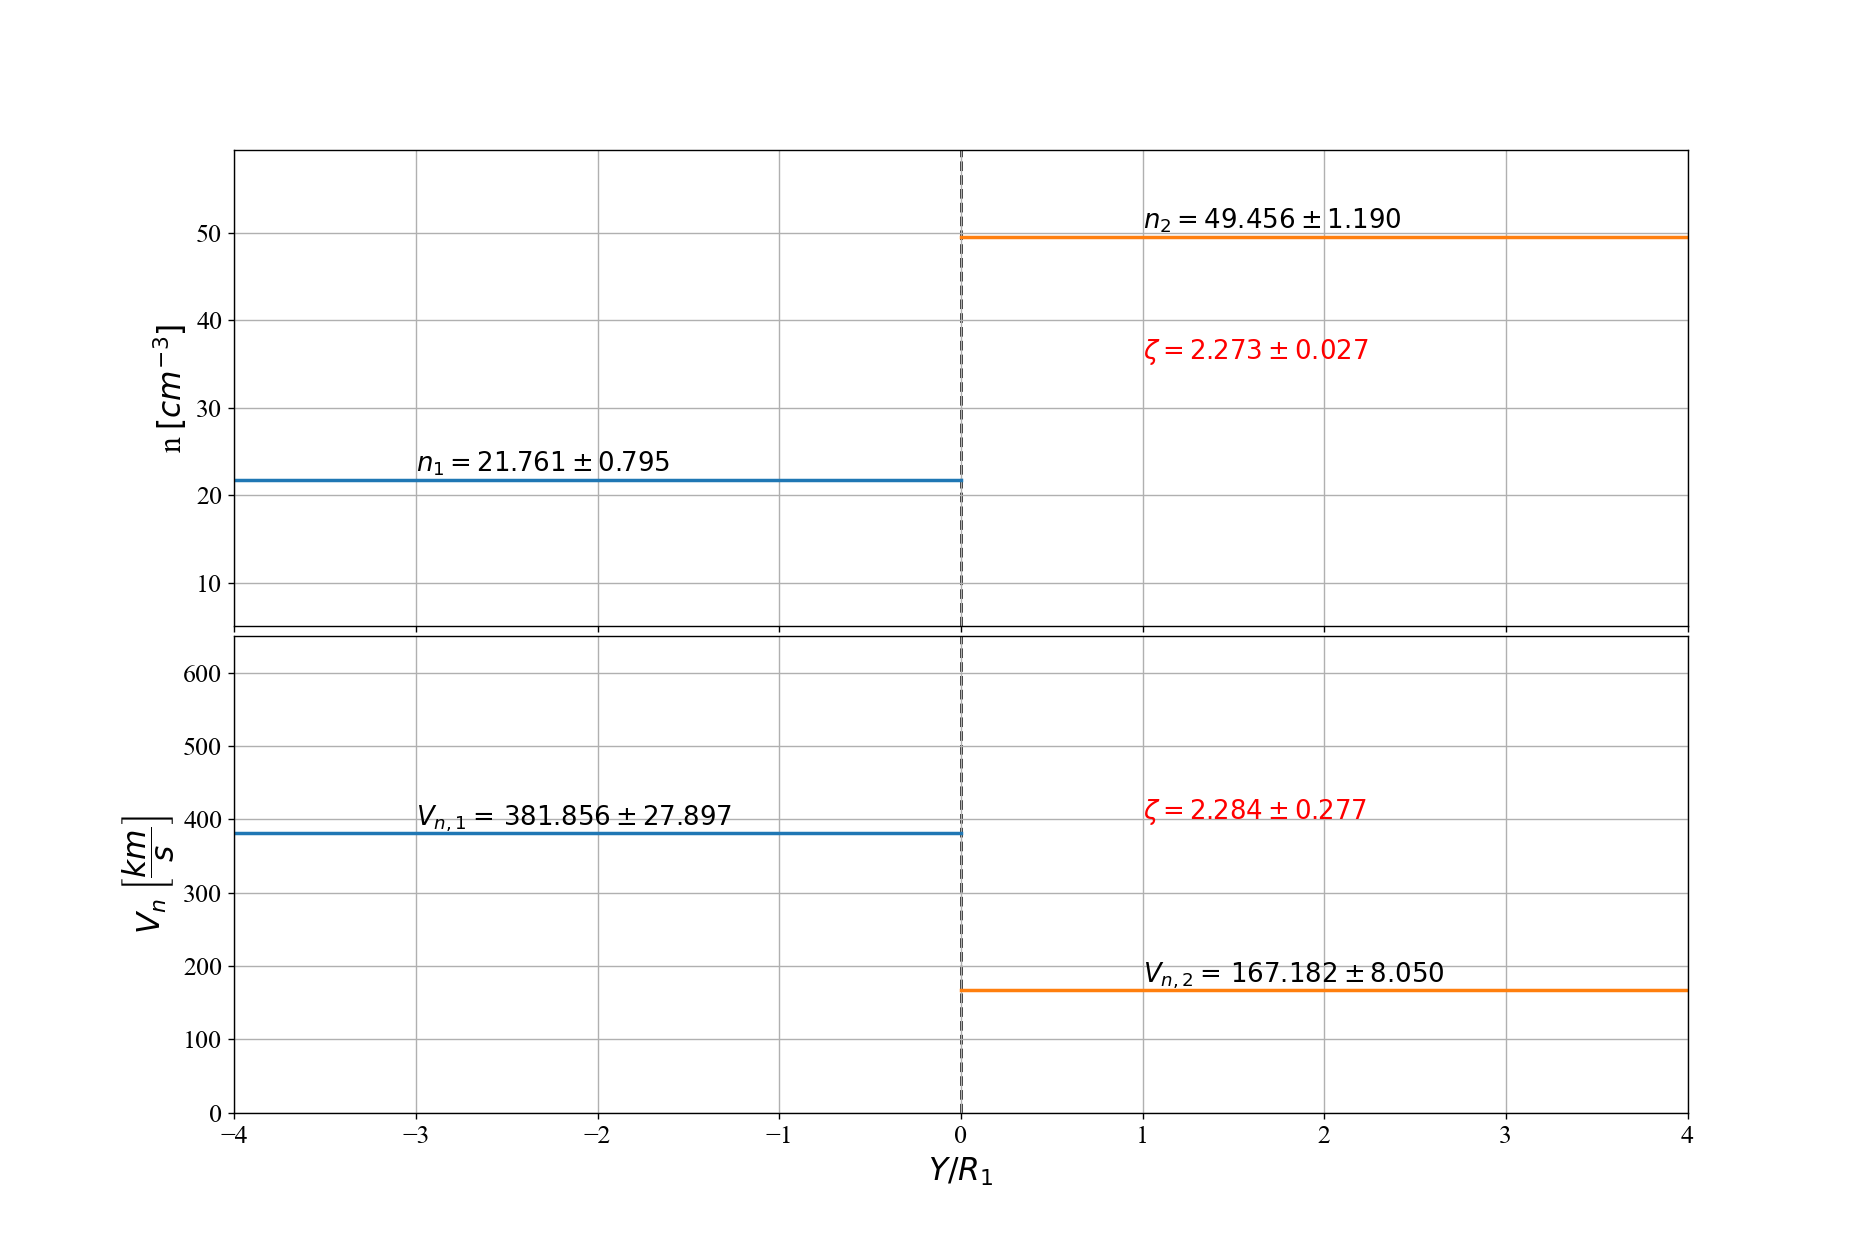

In [60]:
fig,ax = plt.subplots(2,gridspec_kw={'hspace': 0.02},figsize=(15,10))

n_1 = np.linspace(d_up, d_up, 50)
n_2 = np.linspace(d_dw, d_dw, 50)

v_1 = np.linspace(v_up*1e2, v_up*1e2, 50)
v_2 = np.linspace(v_dw*1e2, v_dw*1e2, 50)

xx_1 = np.linspace(-4,0, 50)
xx_2 = np.linspace(0,4, 50)

#Gráfico de densidade

ax[0].annotate(f'$n_1 = {round(d_up,3)} \pm {round(err_up,3)}$',    xy= (-3,d_up+1), size=15)  
ax[0].annotate(f'$n_2 = {round(d_dw,3)} \pm {round(err_dw,3)}0$',    xy= (1,d_dw+1), size=15)  
ax[0].annotate(f'$\zeta   = {np.round(d_dw/d_up,3)} \pm {round(deln,3)}$',    xy= (1,(d_up+d_dw)/2), size=15, color='red') 

ax[0].set_ylabel(r'n $\left[ cm^{-3} \right]$', size=18)
ax[0].plot(xx_1, n_1, lw=2)
ax[0].plot(xx_2, n_2, lw=2)
ax[0].axvline(0, ls = '--', c = 'k', zorder=1)
ax[0].grid(axis='both')
ax[0].set_ylim([5,d_dw+10])
ax[0].set_xlim([-4,4])
ax[0].set_xticks(np.arange(-4,4.1))

ax[0].tick_params(axis='both',labelsize=15)    
ax[0].label_outer()
#ax[0].set_aspect(1)

#Gráfico da velocidade

ax[1].annotate("$V_{n,1}$" + f'$ =  \, {round(v_up*1e2,3)} \pm {round(Del_vup*1e2,3)}$', xy= (-3,v_up*1e2+10), size=15)  
ax[1].annotate("$V_{n,2}$" + f'$ =  \, {round(v_dw*1e2,3)} \pm {round(Del_vdw*1e2,3)}0$', xy= (1,v_dw*1e2+10), size=15)  
ax[1].annotate(f'$\zeta   = {np.round(v_up/v_dw,3)} \pm {round(del_rv,3)}$',    xy= (1,400), size=15, color='red') 


ax[1].set_ylabel(r'$V_n$ '+ r'$ \left[\dfrac{km}{s} \right]$', size=18)
ax[1].set_xlabel(r'$Y/R_1$', size=18)
ax[1].plot(xx_1, v_1, lw=2)
ax[1].plot(xx_2, v_2, lw=2)
ax[1].axvline(0, ls = '--', c = 'k', zorder=1)
ax[1].grid(axis='both')
ax[1].set_ylim([0,650]);
ax[1].set_xlim([-4,4])
ax[1].set_xticks(np.arange(-4,4.1))

ax[1].tick_params(axis='both',labelsize=15)  
#ax[1].set_aspect(1)

#plt.savefig('MonteCarloParametrosfisicos_07102015.png', bbox_inches='tight',facecolor='w', edgecolor='w')

plt.savefig('MonteCarloParametrosfisicos_07102015.png',dpi=300, bbox_inches='tight',facecolor='w', edgecolor='w')

plt.show()

### Cálculo da densidade média, em x/R1, ao longo de y/R1 

In [65]:
nerror_up = np.array(nsig_up.sum()/100)
nerror_dw = np.array(nsig_dw.sum()/100)

In [66]:
n_error = np.concatenate((nerror_dw,nerror_up)) # Juntos os dois vetores contendo os erros das medidas de densidade
#n_error

In [67]:
n_m = n_mass.describe().loc['mean']
n_M = np.array(n_m)
n_m

-3.95     21.612558
-3.85     22.256924
-3.75     21.824507
-3.65     21.832348
-3.55     21.848357
            ...    
 19.55    50.078790
 19.65    50.529654
 19.75    50.600056
 19.85    50.772156
 19.95    50.990579
Name: mean, Length: 240, dtype: float64

In [68]:
max(n_M)+5

90.73952801499911

<IPython.core.display.Javascript object>


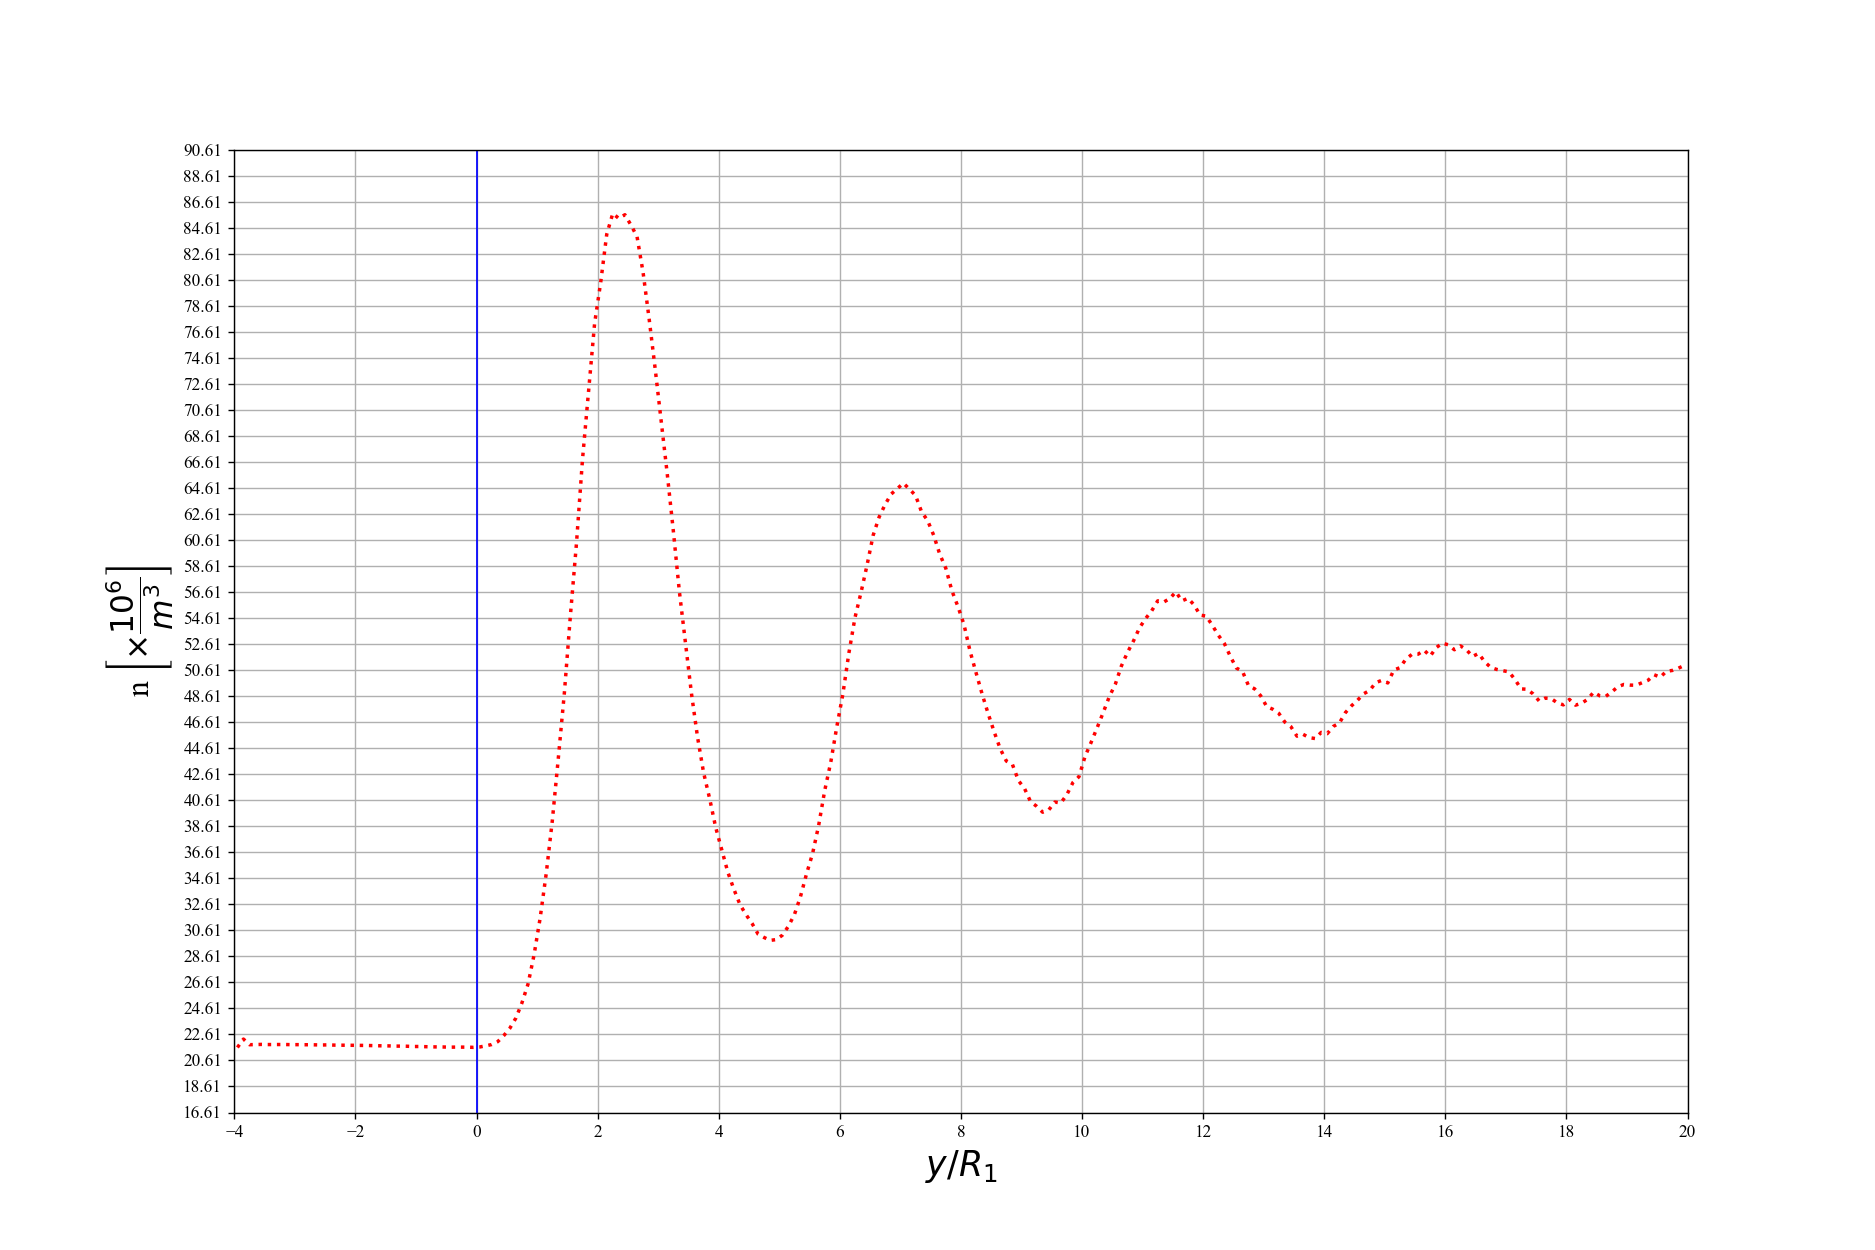

In [72]:
y_d = np.arange(y_1+dy/2,y_2,dy) 

fig,ax = plt.subplots(gridspec_kw={'hspace': 0.02},figsize=(15,10))

ax.plot(y_d, n_M, lw=2, ls=':', color='r')
ax.axvline(0 , color='b',lw=1)
#ax.scatter(y_d[78],n_M[78], lw=10, s=1)

ax.set_xlim([-4,20])
ax.set_xticks(np.arange(-4,20.1,2))
ax.set_yticks(np.arange(min(n_M)-5,max(n_M)+5,2))

ax.set_xlabel(r'$y/R_1$',size= 20)
ax.set_ylabel(r'n $\left[\times \dfrac{10^6}{m^3} \right]$', size=18, color='black')


ax.grid()

## Gráficos adicionais 

In [ ]:
x0lower = -5.0
x0upper = 5.0 

x0 = 0.0
y0 = -4.0*R1 
z0 = 0.0

y_p = 5.1526656924467975

In [ ]:
rx.shape

In [ ]:
rx[:,0].shape

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,20))

# Plot da densidade de pontos
ax.scatter(rx[:,0:50000:20]/R1,ry[:,0:50000:20]/R1,s=0.00002, color='k')

#Trajetórias específicas 
#ax.scatter(rx[:,0]/R1  , ry[:,0]/R1,s=0.5,marker='.', color='r')

#ax.scatter(rx[:,700]/R1, ry[:,700]/R1,s=0.5,marker='.', color='g')

for i in range(0,7):
    
    ax.axhline(y= (1/2+i)*y_p, color='blue', linestyle='--')
    ax.scatter(rx[:,200*i]/R1  , ry[:,200*i]/R1,s= 1 ,marker='.')

ax.axhline(y=0.0, color='k', linestyle='--')
ax.axhline(y=32., color='k', linestyle='--')

ax.set_ylim([-4,40.5]); 
ax.set_xlim([-5,5])

ax.set_xticks(np.arange(-5,5.1,1))

ax.set_yticks(np.arange(-4,40.1,0.5))

ax.set_xlabel(r'$x/R_1$',size=20);ax.set_ylabel(r'$y/R_1$',size= 20)
ax.grid(axis='both')

ax.set_aspect(1)

In [ ]:
fig,ax = plt.subplots(3,gridspec_kw={'hspace': 0.2},figsize=(20,15))
    
for i in range(0,7):
    
    ax[0].scatter(np.arange(1,ek.shape[0]+1), ek[:,200*i], s= 1 ,marker='.')
    ax[1].scatter(np.arange(1,mu.shape[0]+1), mu[:,200*i], s= 1 ,marker='.')
    ax[2].scatter(np.arange(1,rL.shape[0]+1), rL[:,200*i], s= 1 ,marker='.')
    
it1 = np.abs(ry[:,400]).argmin()
it2 = np.abs(ry[:,1200]).argmin()

ax[0].set_ylabel(r'$eK$', size=20)
ax[1].set_ylabel(r'$mu$', size=20)
ax[2].set_ylabel(r'$r_L$', size=20)

for i in range(0,3):
    ax[i].axvline(x = it1, color='k', linestyle='--',lw=2, zorder=10)
    ax[i].axvline(x = it2, color='k', linestyle='--',lw=2, zorder=10)
    
    ax[i].set_xlabel(r'$t$', size=20);
    ax[i].grid(axis='both')
    

plt.show()